# Creating neural networks with PyTorch

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us.

In [6]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. We'd use this to loop through the dataset for training, but here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

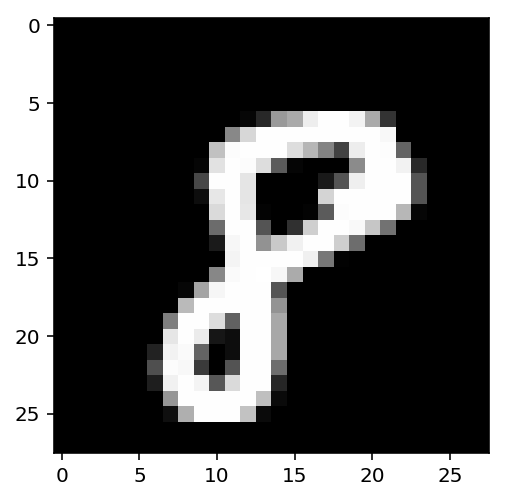

In [8]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## Building networks with PyTorch

Here I'll use PyTorch to build a simple feedfoward network to classify the MNIST images. That is, the network will receive a digit image as input and predict the digit in the image.

<img src="assets/mlp_mnist.png" width=600px>

To build a neural network with PyTorch, you use the `torch.nn` module. The network itself is a class inheriting from `torch.nn.Module`. You define each of the operations separately, like `nn.Linear(784, 128)` for a fully connected linear layer with 784 inputs and 128 units.

The class needs to include a `forward` method that implements the forward pass through the network. In this method, you pass some input tensor `x` through each of the operations you defined earlier. The `torch.nn` module also has functional equivalents for things like ReLUs in `torch.nn.functional`. This module is usually imported as `F`. Then to use a ReLU activation on some layer (which is just a tensor), you'd do `F.relu(x)`. Below are a few different commonly used activation functions.

<img src="assets/activation.png" width=700px>

So, for this network, I'll build it with three fully connected layers, then a softmax output for predicting classes. The softmax function is similar to the sigmoid in that it squashes inputs between 0 and 1, but it's also normalized so that all the values sum to one like a proper probability distribution.

In [15]:
from torch import nn
from torch import optim
import helper
import torch.nn.functional as F

In [16]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    # X is the tensor
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Initializing Weights

In [17]:
print('FC1 Weights', model.fc1.weight)
print('FC1 Bias', model.fc1.bias)

FC1 Weights Parameter containing:
tensor([[ 0.0002, -0.0279, -0.0299,  ...,  0.0018, -0.0177,  0.0089],
        [-0.0257,  0.0256,  0.0228,  ..., -0.0304,  0.0263,  0.0339],
        [ 0.0246, -0.0325,  0.0275,  ...,  0.0005,  0.0091, -0.0180],
        ...,
        [ 0.0074,  0.0073, -0.0345,  ...,  0.0298, -0.0198,  0.0018],
        [ 0.0312,  0.0002,  0.0045,  ...,  0.0288, -0.0194, -0.0282],
        [ 0.0053, -0.0080, -0.0042,  ...,  0.0226,  0.0036,  0.0314]],
       requires_grad=True)
FC1 Bias Parameter containing:
tensor([-0.0097, -0.0212,  0.0205,  0.0259,  0.0331,  0.0040, -0.0176,  0.0268,
         0.0336,  0.0129,  0.0314, -0.0185, -0.0099, -0.0278,  0.0338,  0.0133,
         0.0137,  0.0280, -0.0146,  0.0241,  0.0255, -0.0231, -0.0099,  0.0017,
        -0.0057,  0.0295,  0.0180,  0.0156,  0.0087, -0.0231, -0.0198, -0.0343,
         0.0042,  0.0119,  0.0187,  0.0137,  0.0075, -0.0225,  0.0161, -0.0027,
         0.0087,  0.0119,  0.0158, -0.0299,  0.0243,  0.0160, -0.0262, -0.

In [18]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 0.0122, -0.0092, -0.0162,  ...,  0.0012,  0.0082, -0.0060],
        [-0.0126, -0.0191, -0.0045,  ..., -0.0059,  0.0056,  0.0002],
        [-0.0108, -0.0074,  0.0017,  ...,  0.0113,  0.0053,  0.0012],
        ...,
        [ 0.0057, -0.0088, -0.0170,  ..., -0.0070,  0.0069, -0.0095],
        [ 0.0071, -0.0026, -0.0058,  ...,  0.0055,  0.0118, -0.0053],
        [-0.0221,  0.0053, -0.0037,  ...,  0.0144,  0.0010,  0.0088]])

### Forward pass

Now that we have a network, let's see what happens when we pass in an image. This is called the forward pass. We're going to convert the image data into a tensor, then pass it through the operations defined by the network architecture.

tensor(5)


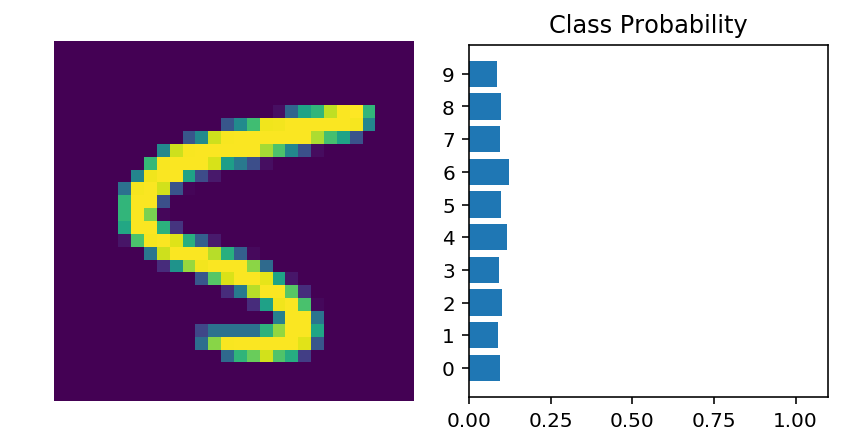

In [23]:
# Grab some data 
dataiter = iter(trainloader)

# Gives you the next batch on the training data
images, labels = dataiter.next()

# From 28 to 28 we resize to 784
# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels)
# Images.shape[0] is the size of the batch
images.resize_(images.shape[0], 1, 784)

# Forward pass through the network
img_idx = 0

# Returns an array of the 10 Probabilities
ps = model.forward(images[img_idx,:])

img = images[img_idx]

helper.view_classify(img.view(1, 28, 28), ps)

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

In [25]:
input_size = 784
hidden_layers = [128, 64]
output_size = 10

model = nn.Sequential(
    nn.Linear(input_size, hidden_layers[0]),
    nn.ReLU(),
    nn.Linear(hidden_layers[0], hidden_layers[1]),
    nn.ReLU(),
    nn.Linear(hidden_layers[1], output_size),
    nn.Softmax(dim=1)
)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


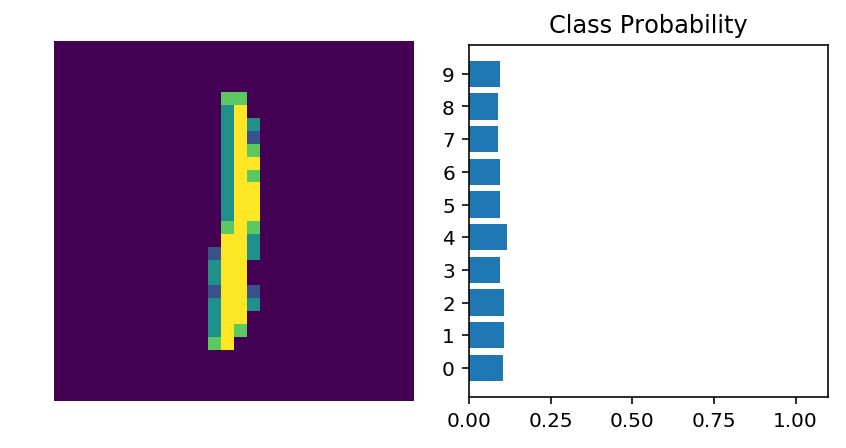

In [26]:
# Grab some data 
dataiter = iter(trainloader)

# Gives you the next batch on the training data
images, labels = dataiter.next()

# From 28 to 28 we resize to 784
# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels)
# Images.shape[0] is the size of the batch
images.resize_(images.shape[0], 1, 784)

# Forward pass through the network
img_idx = 0

# Returns an array of the 10 Probabilities
ps = model.forward(images[img_idx,:])

img = images[img_idx]

helper.view_classify(img.view(1, 28, 28), ps)

You can also pass in an `OrderedDict` to name the individual layers and operations. Note that a dictionary keys must be unique, so _each operation must have a different name_.

In [28]:
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_layers[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_layers[0], hidden_layers[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_layers[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

Now it's your turn to build a simple network, use any method I've covered so far. In the next notebook, you'll learn how to train a network so it can make good predictions.

>**Exercise:** Build a network to classify the MNIST images with _three_ hidden layers. Use 400 units in the first hidden layer, 200 units in the second layer, and 100 units in the third layer. Each hidden layer should have a ReLU activation function, and use softmax on the output layer. 

In [32]:
model = nn.Sequential(
    nn.Linear(input_size, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.Softmax(dim=1)
)
model

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
  (7): Softmax()
)

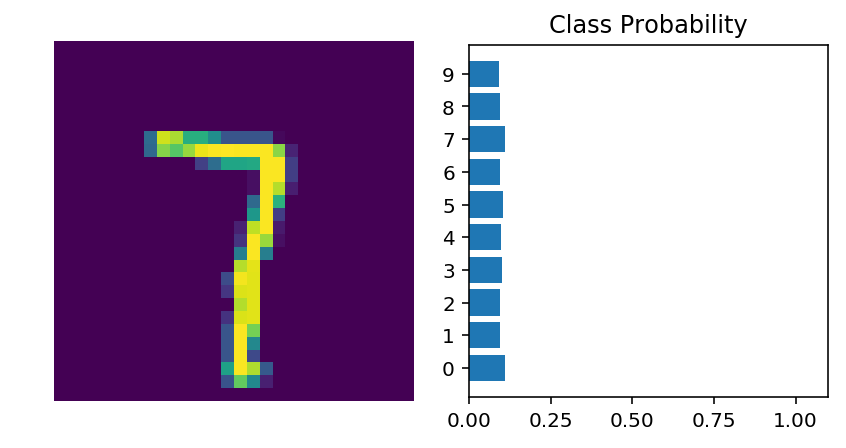

In [34]:
## Run this cell with your model to make sure it works ##
# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)

ps = model.forward(images[0,:])

helper.view_classify(images[0].view(1, 28, 28), ps)